In [51]:
# imports
import os
import torch
import pandas as pd 
from skimage import io, transform
import numpy as np 
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image
import PIL
from PIL import Image
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.ops import box_convert

In [52]:
# check for device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [53]:
root_dir = os.path.join(os.getcwd(), "data" )
root_dir

'g:\\Work\\BMW\\Workbench\\data'

In [55]:
# Image Detection Class
class ImageDetection(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.folders = os.listdir(root_dir)
        self.images = []
        self.json_data = []
        

        for folder in self.folders:
            folder_path = os.path.join(root_dir, folder)
            image_folder = os.path.join(folder_path, "images")
            json_folder = os.path.join(folder_path, "labels", "json")

            for file in os.listdir(image_folder):
                file_path = os.path.join(image_folder, file)
                self.images.append((file_path, folder))
            
            for file in os.listdir(json_folder):
                file_path = os.path.join(json_folder, file)
                self.json_data.append((file_path, folder))

    def images(self):
        return self.json_data

    def load_image(self, idx):
        img_file = self.images[idx][0]
        image = read_image(img_file)
        return Image.open(img_file).convert("RGB")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_file = self.images[idx][0]
        json_file = self.json_data[idx][0]
        image = read_image(img_file)

        # read the json file
        df1 = pd.read_json(json_file)
       
        pen_x = 1
        pen_y = 1

        image_shape = image.shape
        if self.transform:
            image = self.transform(image)
            transformed_image_shape = image.shape
      
            pen_x  =  transformed_image_shape[1] / image_shape[1] 
            pen_y =  transformed_image_shape[2]  /image_shape[2] 
    
        for i in range(len(df1)):
            return img_file, df1["ObjectClassName"][i],df1["ObjectClassId"][i],  df1["Id"][i]  , df1["Left"][i] * pen_y, df1["Top"][i] * pen_x, df1["Right"][i] * pen_y, df1["Bottom"][i] *pen_x
          
transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),  # Resize the image to 256x256  # Crop the image to 224x224
])
data_set = ImageDetection(root_dir, transform=transform)
data_set.__getitem__(2)

('g:\\Work\\BMW\\Workbench\\data\\SORDI_2022_h4001_bicycle\\images\\100.jpg',
 'bicycle',
 2000,
 100,
 18.05,
 13.511111111111111,
 36.0,
 59.37777777777778)

TypeError: new(): invalid data type 'str'

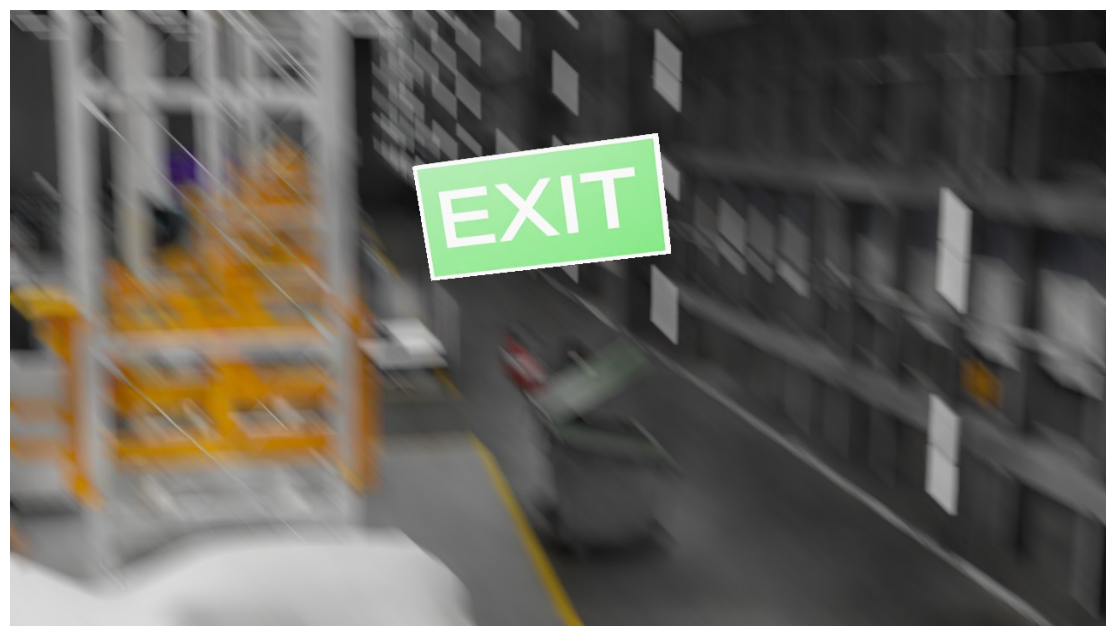

In [63]:
def display_random_images(data_set, n = 10, display_shape = True, seed = None):

    if n > 10:
        n = 10
        display_shape = False
    
    if seed:
        np.random.seed(seed)
    
    random_sample_idx = np.random.randint(0, len(data_set), n)

    plt.figure(figsize=(16,8))

    for i,idx in enumerate(random_sample_idx):
        b_image, class_name, class_id, image_id , left, top, right, bottom = data_set.__getitem__(idx)

        # targ_image_adjust = b_image.permute(1,2,0)

        plt.subplot(1, n, i+1)
        # plt.imshow(b_image)

        # convert image url to plt image
        plt.imshow(Image.open(b_image))     

        plt.axis('off')

        title = f"Label: {class_name}"
        # title = title + f"\nshape: {torch.Tensor(b_image).shape}"

        # matplotlib create bouding box from coordinates
        targ_bbox = [left, top, right, bottom]
        print(targ_bbox)
        rect = plt.Rectangle((left, top), right - left, bottom - top, fill=False, color='red')
        plt.gca().add_patch(rect)
        plt.title(title)
       

display_random_images(data_set, 1, seed = 0)


In [44]:
train_data_set, test_data_set = torch.utils.data.random_split(data_set, [int(len(data_set)*0.75), int(len(data_set)*0.25)+1])
BATCH_SIZE = 34
NUM_WORKERS = os.cpu_count()
train_data_loader_custom = DataLoader(dataset=train_data_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_data_loader_custom = DataLoader(dataset=test_data_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS )


66 435
